# PyTorch Introduction

# Components of Network Training

1. Dataset
2. Network
3. Optimizer
4. Training Loop

In [25]:
from pathlib import Path

In [7]:
import torch
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self): ...

    def __len__(self): ...

    def __getitem__(self, index: int): ...

In [4]:
import torch
from torch.utils.data import Dataset
import numpy as np

class InMemoryDataset(Dataset):
    def __init__(self, dataset_root_folder: Path):
        samples = np.load(dataset_root_folder / 'samples.npy')

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index: int):
        return self.samples[index]

In [5]:
from PIL import Image
import torch
from torch.utils.data import Dataset


class OutOfMemoryDataset(Dataset):
    def __init__(self, dataset_root_folder: Path, transforms):
        self.transforms = transforms

        self.image_files = list(dataset_root_folder.iterdir())

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index: int):
        image = Image.load(self.images_files[index])
        return self.transforms(image)

# Dataset + DataLoader

Dataset: produces sample by index

Dataloader: incupsulates Dataset to generate stream of butchs of samples

In [ ]:
from torch.utils.data import DataLoader

dataset = MyDataset()
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=8,
)

# DataLoader and python trees

1. Tensor of shape [A1, ..., Ak] -> batch-tensor [BATCH_SIZE, A_1, ..., Ak]
2. Tuple/list of tensors -> tuple/list of batch-tensors
3. Dict -> recursively values of Dict

Good idea to return sample as dicts:
```python
{
    'image': image_tensor,
    'mask': mask_tensor,
    'label': label,
}
```

# Layer Examples. Linear

```
torch.nn.Linear: [..., C_in] -> [..., C_out]
```

In [23]:
import torch

linear = torch.nn.Linear(
    in_features=10,
    out_features=20,
    bias=True
)

x_in = torch.randn(16, 10)
print(linear(x_in).shape)

x_in = torch.randn(16, 3, 3, 3, 10)
print(linear(x_in).shape)

torch.Size([16, 20])
torch.Size([16, 3, 3, 3, 20])


# Layer Examples. Conv

```
torch.nn.Conv2d: [BS, C_in, H, W] -> [BS, C_out, H', W']
```

In [24]:
import torch

conv = torch.nn.Conv2d(
    in_channels=10,
    out_channels=20,
    kernel_size=3,
)

x_in = torch.randn(16, 10, 32, 32)
print(conv(x_in).shape)

conv = torch.nn.Conv2d(
    in_channels=10,
    out_channels=20,
    kernel_size=3,
    padding=1,
)
x_in = torch.randn(16, 10, 32, 32)
print(conv(x_in).shape)

# Does not work:
# x_in = torch.randn(16, 2, 10, 32, 32)
# print(conv(x_in).shape)

# Output size= (Input size+2×padding−kernel size)/stride + 1


torch.Size([16, 20, 30, 30])
torch.Size([16, 20, 32, 32])


# Layer Examples. Pooling

```
torch.nn.MaxPool2d: [BS, C, H, W] -> [BS, C, H', W']
```

In [ ]:
import torch

pool = torch.nn.MaxPool2d(
    kernel_size=2,
)

x_in = torch.randn(16, 10, 32, 32)
print(pool(x_in).shape)

torch.Size([16, 10, 16, 16])


# Layer Examples. BatchNorm2d

```
torch.nn.BatchNorm2d: [BS, C, H, W] -> [BS, C, H, W]
```

In [ ]:
import torch

batch_norm = torch.nn.BatchNorm2d(10)

x_in = torch.randn(16, 10, 32, 32)
print(batch_norm(x_in).shape)

torch.Size([16, 10, 32, 32])


# Network architeture: `nn.Module`

*Layers* and *Networks* are indistinguishable:

1. They are transformations from input tensors to output tensors
2. They have weights (trainable, non-trainable and semi-trainable parameters)
3. They have hyperarameters

In [ ]:
from torch import nn


class LayerOrNetwork(nn.Module):
    def __init__(self, hyperparameters):
        super().__init__()
        ...

    def forward(self, x):
        ...
        return y

In [2]:
import torch
from torch import nn

In [14]:
class SimpleConv(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.pooling = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(64, 1)
        #self.weight = nn.Parameter(torch.randn(3, 3))  # Example of trainable weight
        #self.register_buffer('running_mean', torch.zeros(3, 3))

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = nn.functional.relu(x)

        x = self.conv3(x)
        x = nn.functional.relu(x)

        x = self.pooling(x)

        x = x.squeeze(-1).squeeze(-1)

        x = self.linear(x)
        #x= torch.matmul(x, self.weight)
        # x = x + self.running_mean
        return x

In [15]:
x = torch.randn(1, 3, 32, 32)

model = SimpleConv()

output = model(x)

print("Output shape:", output)

Output shape: tensor([[-0.0795]], grad_fn=<AddmmBackward0>)


In [16]:
for name, param in model.named_parameters():
    print(name, param.shape)

conv1.weight torch.Size([64, 3, 3, 3])
conv1.bias torch.Size([64])
conv2.weight torch.Size([64, 64, 3, 3])
conv2.bias torch.Size([64])
conv3.weight torch.Size([64, 64, 3, 3])
conv3.bias torch.Size([64])
linear.weight torch.Size([1, 64])
linear.bias torch.Size([1])


In [17]:
params = list(model.parameters())
#print(params)
buffers = list(model.buffers())
print(buffers)

[]


In [19]:
input_tensor = torch.randn(1, 3, 4, 4)

adaptive_pooling = nn.AdaptiveAvgPool2d(output_size=1)


output_tensor = adaptive_pooling(input_tensor)

print("Output shape:", output_tensor.shape)

Output shape: torch.Size([1, 3, 1, 1])


# Training Loop

```
Instantiate dataset + dataloader
Instantiate neural network

while True:
    Generate batch
    Pass input tensors through batch
    Compare network output with targets and compute loss
    Calculate gradients of loss w.r.t. network parameters
    Update network weights
```

In [ ]:
network
# network.submodule1.weight1
# network.submodule1.submodule2.weight2

x, y                # input tensor and output tensor
y_hat = network(x)  # network output
loss = ((y - y_hat)**2).mean()

loss.backward()
# network.submodule1.weight1.grad <- d loss / d weight1
# network.submodule1.weight2.grad <- d loss / d weight2

In [ ]:
#initialization
optimizer = torch.optim.SGD(network.parameters(), lr=1e-1)

...

#inside training loop:
while True:
    ...
    loss = ...

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
dataset = MyDataset()

dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=8)

network = SimpleConv()

optimizer = torch.optim.SGD(network.parameters(), lr=1e-1)

while True:
    for batch in dataloader:
        images, targets = batch

        network_outputs = network(images)

        loss = ((targets - network_outputs)**2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(loss.item())

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR


network = SimpleConv()

optimizer = torch.optim.SGD(network.parameters(), lr=1e-1)

scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0) #T_max is the number of epochs for which the learning rate will anneal (complete one cycle), and eta_min is the minimum learning rate.

#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True) #This scheduler reduces the learning rate when a metric has stopped improving.

#scheduler = ExponentialLR(optimizer, gamma=0.9)

num_epochs = 100

for epoch in range(num_epochs):

    for batch in dataloader:
        images, targets = batch

        network_outputs = network(images)

        loss = ((targets - network_outputs)**2).mean()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    # Update the learning rate scheduler
    scheduler.step()


# Task.

Train neural network to square 1-dimensional input tensor $x \rightarrow x^2$

1. Implement Dataset that would generate sample pairs $(x, x^2), x \in [-3; 3]$
2. Implement multi-layer perceptron.
3. Create dataset, dataloader, network instance and optimizer
4. Implement training loop and train your neural network

In [ ]:
import random

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt


class SqrDataset(Dataset):
    def __len__(self):
        return 10**6

    def __getitem__(self, _):
        x = random.random() * 6 - 3
        return torch.tensor([x]), torch.tensor([x**2])


class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(1, 32)
        self.linear2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = nn.functional.relu(x)
        x = self.linear2(x)

        return x


dataset = SqrDataset()
dataloader = DataLoader(dataset, 2**10, False, num_workers=0)


network = Network()
optimizer = torch.optim.Adam(network.parameters())

for x, y in dataloader:
    network_output = network(x)
    loss = ((network_output - y)**2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(loss.item())


xs = torch.linspace(-3, 3, 1000)[:, None]
ys = network(xs)



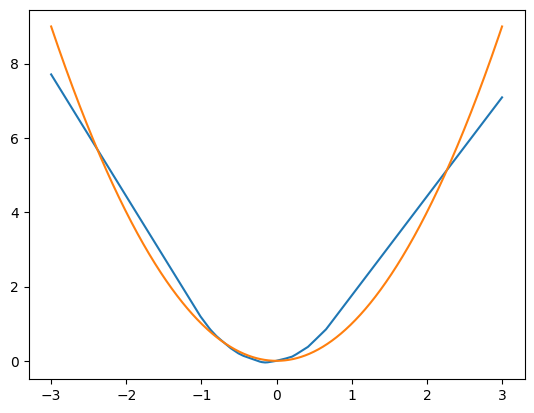

In [12]:
plt.plot(xs.detach().numpy(), ys.detach().numpy())
plt.plot(xs.detach().numpy(), xs.detach().numpy()**2)
plt.savefig('./a.png')
plt.show()

# CNN zoo



In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


model_name = 'resnet18'

if model_name == 'vgg16':
    model = torchvision.models.vgg16(pretrained=True)
elif model_name == 'resnet18':
    model = torchvision.models.resnet18(pretrained=True)
elif model_name == 'mobilenet_v2':
    model = torchvision.models.mobilenet_v2(pretrained=True)
else:
    raise ValueError("Invalid model name. Choose from 'vgg16', 'resnet18', 'mobilenet_v2'.")

# Fine-tune
if model_name != 'mobilenet_v2':
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
else:
    model.classifier[1] = nn.Linear(1280, 10)

# Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0


100%|██████████| 170498071/170498071 [00:05<00:00, 31937819.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


[1,   100] loss: 1.701
[1,   200] loss: 1.191
[1,   300] loss: 1.050
[1,   400] loss: 0.951
[1,   500] loss: 0.908
[1,   600] loss: 0.841
[1,   700] loss: 0.815
[2,   100] loss: 0.659
[2,   200] loss: 0.642
[2,   300] loss: 0.670
[2,   400] loss: 0.652
[2,   500] loss: 0.632
[2,   600] loss: 0.614
[2,   700] loss: 0.623
[3,   100] loss: 0.464
[3,   200] loss: 0.489
[3,   300] loss: 0.483
[3,   400] loss: 0.486
[3,   500] loss: 0.482
[3,   600] loss: 0.481
[3,   700] loss: 0.473
[4,   100] loss: 0.340
[4,   200] loss: 0.362
[4,   300] loss: 0.378
[4,   400] loss: 0.374
[4,   500] loss: 0.368
[4,   600] loss: 0.383
[4,   700] loss: 0.391
[5,   100] loss: 0.257
[5,   200] loss: 0.273
[5,   300] loss: 0.259
[5,   400] loss: 0.301
[5,   500] loss: 0.279
[5,   600] loss: 0.309
[5,   700] loss: 0.315
[6,   100] loss: 0.196
[6,   200] loss: 0.203
[6,   300] loss: 0.211
[6,   400] loss: 0.218
[6,   500] loss: 0.238
[6,   600] loss: 0.236
[6,   700] loss: 0.242
[7,   100] loss: 0.168
[7,   200] 

In [1]:
import torch
import torchvision
model1 = torchvision.models.resnet18(pretrained=True)
print(model1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  